# Lab 9 

## Integrantes: 
- **Nombre:** Juan Avila - 20090
- **Nombre:** Sebastian Aristondo - 20880
- **Nombre:** Daniel González - 20293
- **Nombre:** Manuel Archila - 161250
- **Nombre:** Diego Franco - 20240


In [97]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
import random as rand
import torch.utils.data as data
import seaborn as sns

# Task 1: Práctica

## 1. Preparacion de datos

a.  Limpieza de datos: Maneje valores faltantes, anomalías o valores atípicos en el conjunto de datos.


b. Transformación de datos: Convierta los datos a un formato adecuado para modelar, incluyendo normalización o escalado si es necesario.


In [98]:
data = pd.read_csv('./Data/train.csv')
data.head(-10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912985,2017-12-17,10,50,86
912986,2017-12-18,10,50,53
912987,2017-12-19,10,50,54
912988,2017-12-20,10,50,51


In [99]:
data.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [100]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [101]:
data['date'] = pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


## 2.   Preprocesamiento de datos

In [102]:
print('Min date from train set: %s' % data['date'].min().date())
print('Max date from train set: %s' % data['date'].max().date())

ultimo_mes = data['date'].max()
primer_mes = ultimo_mes - pd.DateOffset(months=3)

train = data[data['date'] < primer_mes]
test = data[data['date'] >= primer_mes]

Min date from train set: 2013-01-01
Max date from train set: 2017-12-31


In [103]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
store_daily_sales_test = test.groupby(['store', 'date'], as_index=False)['sales'].sum()

#item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()


In [104]:
store_daily_sales.head(-20)

,store,date,sales
0,1,2013-01-01,1316
1,1,2013-01-02,1264
2,1,2013-01-03,1305
3,1,2013-01-04,1452
4,1,2013-01-05,1499
...,...,...,...
17305,10,2017-09-05,3204
17306,10,2017-09-06,3168
17307,10,2017-09-07,3494
17308,10,2017-09-08,3709


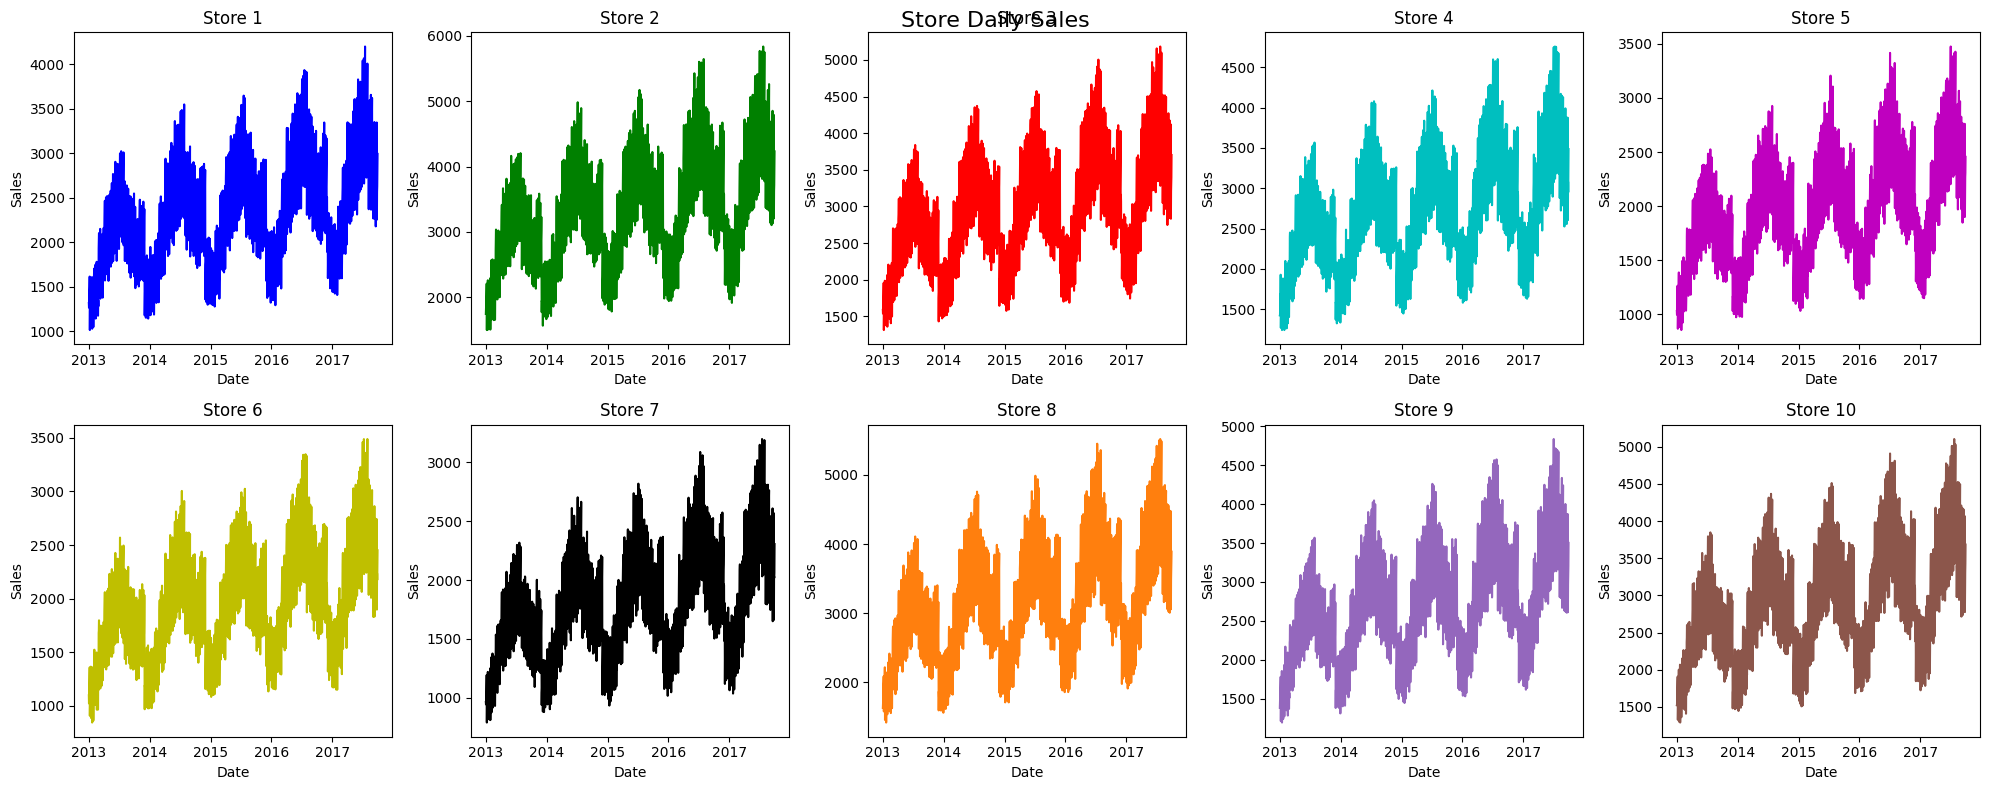

In [105]:
import matplotlib.pyplot as plt

rows = 2  
cols = 5  

fig, axs = plt.subplots(rows, cols, figsize=(20, 8))
colores = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:orange', 'tab:purple', 'tab:brown']

for i in range(1, 11):
    row = (i - 1) // cols  
    col = (i - 1) % cols  

    temp = store_daily_sales[store_daily_sales.store == i]
    axs[row, col].plot(temp['date'], temp['sales'], color=colores[i-1])
    axs[row, col].set_title('Store %d' % i)
    axs[row, col].set_xlabel('Date')
    axs[row, col].set_ylabel('Sales')

plt.tight_layout()
fig.suptitle('Store Daily Sales', fontsize=16)
plt.show()


## 3.   Selección de modelo


Como grupo decidimos que implementaríamos una LSTM

## 4.   Arquitectura modelo

- a. Diseñe la arquitectura de la red neuronal, que puede incluir:
- i. Capas LSTM/GRU/Conv1D con unidades o filtros adecuados.
- ii. Capas adicionales como capas Densas para predicciones finales.
- iii. Capas de dropout para evitar el overfitting.
- iv. Otros componentes como la normalización por batches, funciones de activación y funciones avanzadas como mecanismos de atención.

In [106]:
scaler = MinMaxScaler()

In [107]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_layer_size, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [108]:
def create_sequences(data, seq_length):
    sequences, labels = [], []
    datos = data[['sales']].values.astype('float32')
    datos = scaler.fit_transform(datos)
    for i in range(data.shape[0] - seq_length):
        seq = datos[i:i+seq_length]
        label = datos[i+1:i+seq_length+1]
        sequences.append(seq)
        labels.append(label)
        
    sequences = np.array(sequences)
    labels = np.array(labels)
    torch_sequences = torch.tensor(sequences)
    torch_labels = torch.tensor(labels)
    return torch_sequences, torch_labels


In [109]:
def get_data(data, sequence_length=5):
    sequence_length = sequence_length
    X, y = create_sequences(data, sequence_length)
    return X, y


## 5.   Entrenamiento

In [110]:
def graph_loss(loss_train, loss_test, model):
    # Visualización del rendimiento
    epoch = np.arange(len(loss_train))
    plt.figure()
    plt.title('Loss modelo ' + str(model))
    plt.plot(epoch, loss_train, 'r', label='Training',)
    plt.plot(epoch, loss_test, 'b', label='Test')
    plt.legend()
    plt.xlabel('Epoch'), plt.ylabel('RMSE')
    plt.show()

In [111]:
def train(modelo, loader, n_epochs, model, optimizer, criterion, X_train, y_train, X_test, y_test):
    loss_train = []
    loss_test = []
    print("Train - Modelo", modelo)
    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            X_batch = X_batch
            y_batch = y_batch
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # if epoch % 10 == 0:
        #     print(f'Epoch: {epoch:3} loss: {loss.item():10.8f}')
        if epoch % 100 != 0 and epoch != n_epochs-1:
            continue  
        model.eval()
        
        
        with torch.no_grad():
             #X_train = X_train.to(device)
            # Prediccion
            y_pred = model(X_train)
            # Calculo del RMSE - Root Mean Square Error
            train_rmse = np.sqrt(criterion(y_pred, y_train))
            # Prediccion sobre validation
            y_pred = model(X_test)
            # Calculo del RMSE para validation
            test_rmse = np.sqrt(criterion(y_pred, y_test))
            loss_train.append(train_rmse)
            loss_test.append(test_rmse)
        
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
    return loss_train, loss_test

In [112]:
if torch.cuda.is_available():
    # Crea una variable de dispositivo para la GPU
    device = torch.device("cuda")
else:
    # Si no hay GPU, utiliza la CPU
    device = torch.device("cpu")

In [113]:
from torch.utils.data import DataLoader

input_size = 1
hidden_layer_size = 50
output_size = 1
modelos = []
losses = []

for tienda in range(0, 2):
    tienda += 1
    
    LSTM_i = LSTM(input_size, hidden_layer_size, output_size)
    # LSTM_i.to(device)
    optimizer = optim.Adam(LSTM_i.parameters(), lr=0.001)
    loss_function = nn.MSELoss() 
    
    x_train, y_train = get_data(store_daily_sales[store_daily_sales['store'] == tienda])
    x_test, y_test = get_data(store_daily_sales_test[store_daily_sales_test['store'] == tienda])

    loader = DataLoader((x_train, y_train), batch_size=4, shuffle=True)
    loss_train, loss_test = train(tienda, loader, 1000, LSTM_i, optimizer, loss_function, x_train, y_train, x_test, y_test)
    losses.append((loss_train, loss_test))
    modelos.append(LSTM_i)


Train - Modelo 1
Epoch 0: train RMSE 0.4589, test RMSE 0.5451


Epoch 100: train RMSE 0.1746, test RMSE 0.2403
Epoch 200: train RMSE 0.1370, test RMSE 0.2113
Epoch 300: train RMSE 0.1273, test RMSE 0.2026
Epoch 400: train RMSE 0.1242, test RMSE 0.2010
Epoch 500: train RMSE 0.1236, test RMSE 0.2014
Epoch 600: train RMSE 0.1234, test RMSE 0.2019
Epoch 700: train RMSE 0.1224, test RMSE 0.2003
Epoch 800: train RMSE 0.1250, test RMSE 0.2055
Epoch 900: train RMSE 0.1250, test RMSE 0.2056
Epoch 999: train RMSE 0.1242, test RMSE 0.2044
Train - Modelo 2
Epoch 0: train RMSE 0.4674, test RMSE 0.5524
Epoch 100: train RMSE 0.1871, test RMSE 0.2549
Epoch 200: train RMSE 0.1429, test RMSE 0.2208
Epoch 300: train RMSE 0.1311, test RMSE 0.2096
Epoch 400: train RMSE 0.1279, test RMSE 0.2075
Epoch 500: train RMSE 0.1276, test RMSE 0.2082
Epoch 600: train RMSE 0.1256, test RMSE 0.2050
Epoch 700: train RMSE 0.1273, test RMSE 0.2087
Epoch 800: train RMSE 0.1260, test RMSE 0.2066
Epoch 900: train RMSE 0.1276, test RMSE 0.2097
Epoch 999: train RMSE 0.1271, test RMSE 0.209

## 6.    Evaluación modelo

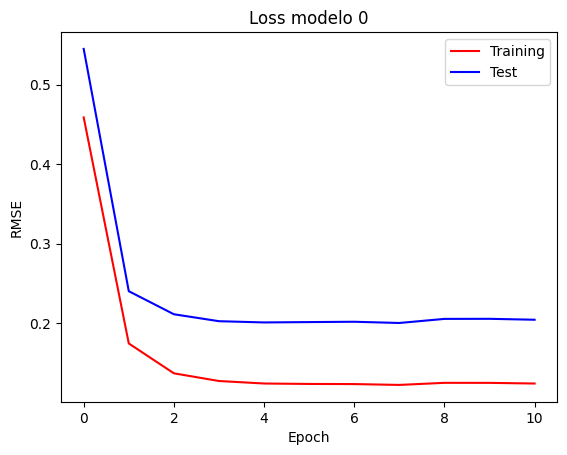

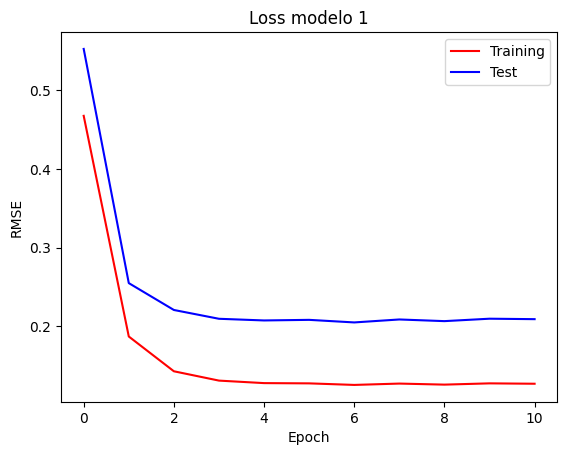

In [114]:
for i, (loss_train, loss_test) in enumerate(losses):
    graph_loss(loss_train, loss_test, i)

## 7.   Ajuste hiperparámetros

In [115]:
import random

# Define the hyperparameter space
hidden_layer_sizes = [20, 50, 100, 150]
learning_rates = [0.001, 0.01, 0.1]
sequence_lengths = [3, 5, 7, 10]

# Define a function to perform evaluation for a given hyperparameter combination
def evaluate_hyperparameters(tienda, hidden_size, lr, seq_length, store_data, store_data_test):
    # Create model with given hyperparameters
    model = LSTM(input_size, hidden_size, output_size)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.MSELoss()

    x_train, y_train = get_data(store_data[store_data['store'] == tienda].copy(), seq_length)
    x_test, y_test = get_data(store_data_test[store_data_test['store'] == tienda].copy(), seq_length)

    loader = DataLoader((x_train, y_train), batch_size=4, shuffle=True)
    _, loss_test = train(tienda, loader, 500, model, optimizer, loss_function, x_train, y_train, x_test, y_test)

    # Return the final test loss
    return loss_test[-1]

# Dictionary to store the best hyperparameters for each store
store_best_hyperparameters = {}
store_best_loss = {}

# Define the number of stores you want to process
num_stores = 2
# Number of random search iterations
n_iterations = 10

for tienda in range(1, num_stores + 1):
    best_loss_for_store = float('inf')
    best_hyperparameters_for_store = None

    print(f"Evaluating Store {tienda}...")
    
    for _ in range(n_iterations):
        # Sample a random hyperparameter combination
        hidden_size = random.choice(hidden_layer_sizes)
        lr = random.choice(learning_rates)
        seq_length = random.choice(sequence_lengths)

        # Evaluate the current combination
        loss = evaluate_hyperparameters(tienda, hidden_size, lr, seq_length, store_daily_sales, store_daily_sales_test)
        print(f"Evaluating: Hidden Size = {hidden_size}, Learning Rate = {lr}, Sequence Length = {seq_length} -> Loss = {loss}")

        # Update best loss and best hyperparameters for the current store
        if loss < best_loss_for_store:
            best_loss_for_store = loss
            best_hyperparameters_for_store = (hidden_size, lr, seq_length)

    # Store the best hyperparameters for the current store
    store_best_hyperparameters[tienda] = best_hyperparameters_for_store
    store_best_loss[tienda] = best_loss_for_store

print(store_best_hyperparameters, store_best_loss)



Evaluating Store 1...
Train - Modelo 1
Epoch 0: train RMSE 0.4731, test RMSE 0.5545
Epoch 100: train RMSE 0.1224, test RMSE 0.2003
Epoch 200: train RMSE 0.1197, test RMSE 0.1968
Epoch 300: train RMSE 0.1197, test RMSE 0.1975
Epoch 400: train RMSE 0.1191, test RMSE 0.1968
Epoch 499: train RMSE 0.1217, test RMSE 0.2002
Evaluating: Hidden Size = 50, Learning Rate = 0.01, Sequence Length = 5 -> Loss = 0.20024454593658447
Train - Modelo 1
Epoch 0: train RMSE 0.3734, test RMSE 0.4586
Epoch 100: train RMSE 0.1203, test RMSE 0.1960
Epoch 200: train RMSE 0.1194, test RMSE 0.1965
Epoch 300: train RMSE 0.1240, test RMSE 0.2041
Epoch 400: train RMSE 0.1252, test RMSE 0.2070
Epoch 499: train RMSE 0.1237, test RMSE 0.2045
Evaluating: Hidden Size = 50, Learning Rate = 0.01, Sequence Length = 5 -> Loss = 0.20449113845825195
Train - Modelo 1
Epoch 0: train RMSE 0.3089, test RMSE 0.3969
Epoch 100: train RMSE 0.1194, test RMSE 0.1970
Epoch 200: train RMSE 0.1184, test RMSE 0.1968
Epoch 300: train RMSE 0.

In [116]:
# Hay que entrenar los modelos con los mejores hiperparámetros
modelos = []
losses = []

for tienda in range(1, num_stores + 1):
    hidden_size, lr, seq_length = store_best_hyperparameters[tienda]
    model = LSTM(input_size, hidden_size, output_size)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.MSELoss()

    x_train, y_train = get_data(store_daily_sales[store_daily_sales['store'] == tienda].copy(), seq_length)
    x_test, y_test = get_data(store_daily_sales_test[store_daily_sales_test['store'] == tienda].copy(), seq_length)

    loader = DataLoader((x_train, y_train), batch_size=4, shuffle=True)
    loss_train, loss_test = train(tienda, loader, 1000, model, optimizer, loss_function, x_train, y_train, x_test, y_test)
    losses.append((loss_train, loss_test))
    modelos.append(model)


Train - Modelo 1
Epoch 0: train RMSE 0.3437, test RMSE 0.4284
Epoch 100: train RMSE 0.1195, test RMSE 0.1975
Epoch 200: train RMSE 0.1307, test RMSE 0.2148
Epoch 300: train RMSE 0.1228, test RMSE 0.2048
Epoch 400: train RMSE 0.1168, test RMSE 0.1961
Epoch 500: train RMSE 0.1160, test RMSE 0.1952
Epoch 600: train RMSE 0.1170, test RMSE 0.1961
Epoch 700: train RMSE 0.1136, test RMSE 0.1902
Epoch 800: train RMSE 0.1226, test RMSE 0.2031
Epoch 900: train RMSE 0.1232, test RMSE 0.2062
Epoch 999: train RMSE 0.1201, test RMSE 0.2013
Train - Modelo 2
Epoch 0: train RMSE 6.7616, test RMSE 6.7302
Epoch 100: train RMSE 0.1254, test RMSE 0.2005
Epoch 200: train RMSE 0.1232, test RMSE 0.1997
Epoch 300: train RMSE 0.1228, test RMSE 0.2005
Epoch 400: train RMSE 0.1297, test RMSE 0.2125
Epoch 500: train RMSE 0.1192, test RMSE 0.1981
Epoch 600: train RMSE 0.1190, test RMSE 0.1985
Epoch 700: train RMSE 0.1236, test RMSE 0.2068
Epoch 800: train RMSE 0.1230, test RMSE 0.2063
Epoch 900: train RMSE 0.1243, 

## 8.   Forecasting

In [117]:
# Define the inverse transform function for the scaler
def inverse_transform(data, scaler):
    data_2D = data.squeeze(-1)
    return scaler.inverse_transform(data_2D)

# Define the predict function
def predict(model, data, seq_length):
    sequences, _ = create_sequences(data, seq_length)
    with torch.no_grad():
        predictions = model(sequences)
    return predictions


In [118]:
tienda = 1
predicciones = []


for modelo in modelos:
    
    test_data = store_daily_sales_test[store_daily_sales_test['store'] == tienda]

    predicciones_tienda = predict(modelo, test_data, 5)
    original_predictions = inverse_transform(predicciones_tienda.numpy(), scaler)
    tienda += 1

    # Use only the last point from each sequence for plotting
    unique_predictions = original_predictions[:, -1]
    predicciones.append(unique_predictions)


## 9.   Visualización

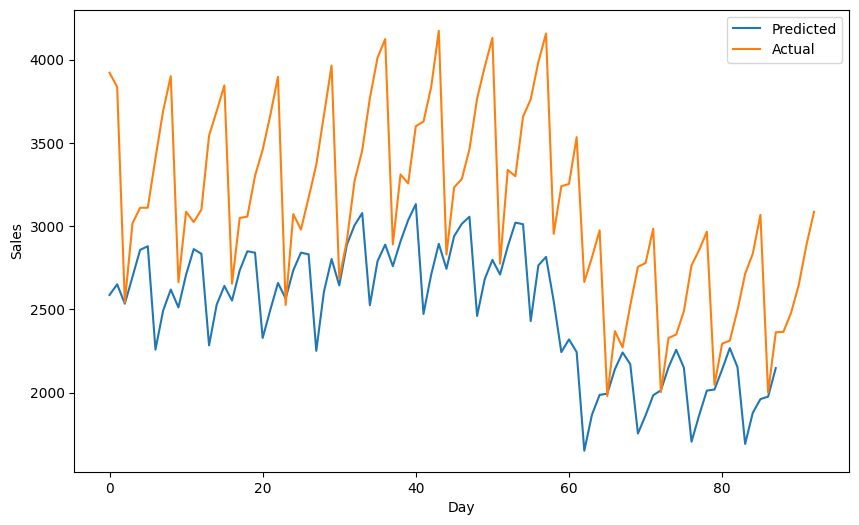

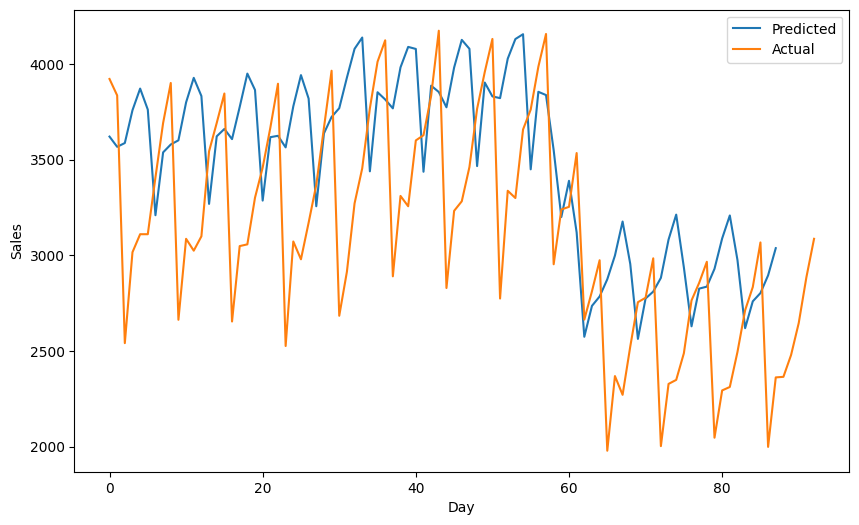

In [119]:
test_data = store_daily_sales_test[store_daily_sales_test['store'] == tienda]

for prediccion in predicciones:
    
    plt.figure(figsize=(10, 6))
    plt.plot(prediccion, label='Predicted')
    plt.plot(test_data['sales'].values, label='Actual')
    plt.xlabel('Day')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

## 10.  Interpretabilidad del modelo

In [120]:
tienda = 1
predicciones = []


ultimo_mes = data['date'].max()
primer_mes = ultimo_mes - pd.DateOffset(months=3)

train = data[data['date'] < primer_mes]
test = data[data['date'] >= primer_mes]

for i in range(1,50,10):
    
    eliminar_item = test[test['store'] == 1]
    eliminar_item = eliminar_item[eliminar_item['item'] != i]
    store_daily_sales = eliminar_item.groupby(['store', 'date'], as_index=False)['sales'].sum()
    test_data = store_daily_sales[store_daily_sales['store'] == tienda]

    predicciones_tienda = predict(modelo, test_data, 5)
    original_predictions = inverse_transform(predicciones_tienda.numpy(), scaler)
    # Use only the last point from each sequence for plotting
    unique_predictions = original_predictions[:, -1]
    predicciones.append(unique_predictions)

    

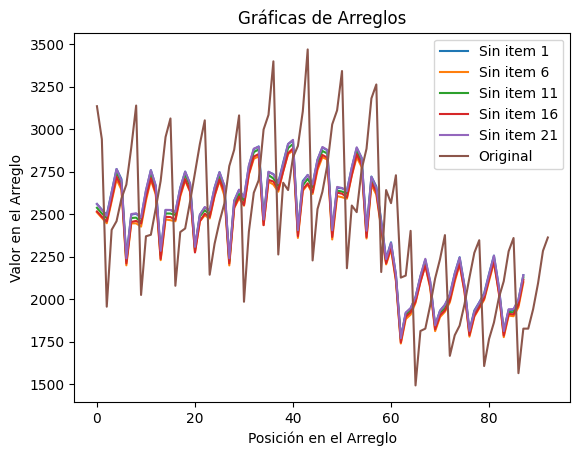

In [121]:
# Crea un rango de valores para el eje x (asumiendo que el número de datos en cada arreglo es el mismo)

# Crea una gráfica para cada arreglo en el arreglo de arreglos

arreglo_de_arreglos = np.array(predicciones)

for i, arreglo in enumerate(arreglo_de_arreglos):
    eje_x = np.arange(len(arreglo_de_arreglos[i]))
    plt.plot(arreglo, label=f"Sin item {i*5+1}")

# Personaliza la gráfica (opcional)
plt.title("Gráficas de Arreglos")
plt.xlabel("Posición en el Arreglo")
plt.ylabel("Valor en el Arreglo")
plt.plot(test_data['sales'].values, label='Original')

# Agrega una leyenda
plt.legend()

# Muestra la gráfica
plt.show()



Decidimos utilizar **Permutation Feature Importance** para ver como afectaba eliminar algunos de los items a las ventas totales. Para ellos generamos nuevos dataset para predecir, en los cuales no se encontraba un item especifico. Dado que son muchos items solo eliminamos algunos de ellos. Como podemos ver en la grafica superior eliminar 1 item modifica ligeramente la predicción, la serie de tiempo solo se desplaza pero no cambia su forma. Esto nos permite concluír que todos los items afectan de una forma muy similar a las ventas totales. No hay un item sobresaliente que afecte de forma significativa a las ventas totales. Es importante destacar que este análisis se utilizo para la tienda 1 eliminando los items 1,6,11,16,21

# Task 2

**1. ¿Cuál es el problema del gradiente de fuga de las redes LSTM y cómo afecta la efectividad de LSTM para el pronóstico de serires temporales ?** 

    - El problema de graiente decendiente ocurre cuando los gradientes de capas anterior se vuelven muy pequeñas a meidida que se retropropagan hacia atrás durante el entrenamiento.Como resultado, los pesos en las capas anteriores se actualizan de manera muy gradual o, en algunos casos, casi no se actualizan en absoluto. Esto dificulta el aprendizaje de dependencias a largo plazo en datos secuenciales, lo que puede dar como resultado predicciones inexactas.
    
**2. ¿Cómo se aborda la estacionalidad en los datos de series temporales cuando se utilizan LSTM para realizar pronósticos y qué papel juega la diferenciación en el proceso?**
    
    - La estacionalidad se aborda con la diferenciación, la cual consiste en restar el valor de la observación en el tiempo t-1 al valor de la observación en el tiempo t. Esto se hace para que los datos sean estacionarios y se puedan utilizar en el modelo. Esto ayuda a estabilizar la media de la serie, lo que a su vez ayuda a estabilizar las predicciones.

**3.¿Cuál es el concepto de "tamaño de ventana" en el pronóstico de series temporales con LSTM y cómo afecta la elección del tamaño de ventana a la capacidad del modelo para capturar patrones a corto y largo plazo?** 

    - Este concepto hace referencia a la cantidad de pasos de tiempo anteriores que se utilizarán como entrada para predecir el siguiente paso de tiempo.

    El tamaño de ventana juega un papel bastante importante en la capacidad del modelo. Por ejemplo, un tamaño de ventana pequeño significa que el modelo solo podrá ver un pequeño número de pasos de tiempo anteriores, lo que significa que solo podrá capturar patrones a corto plazo. Por otro lado, un tamaño de ventana grande significa que el modelo podrá ver un gran número de pasos de tiempo anteriores, lo que significa que podrá capturar patrones a largo plazo. Sin embargo, un tamaño de ventana grande también significa que el modelo tendrá que aprender una gran cantidad de parámetros, lo que puede provocar un sobreajuste.